In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Diagnosing Convergence in MCMC Methods

> "Why does he insist that we must have a diagnosis? Some things are not meant to be known by man."  
> — Susanna Gregory, *An Unholy Alliance*

### Stopping the Chain

In previous chapters, we established the theoretical foundations of MCMC algorithms and showed that, under fairly general conditions, the chains produced by these algorithms are ergodic or even geometrically ergodic. While these developments are theoretically necessary, they are nonetheless insufficient from the implementation perspective of MCMC methods.

The theoretical results don't directly lead to methods for controlling the chain produced by the algorithm (in the sense of a *stopping rule* to guarantee sufficient iterations). In other words, while necessary or mathematical proofs of the validity of MCMC algorithms exist, general convergence results don't tell us when to stop these algorithms to produce reliable estimates.

For instance, the mixture model of Example 10.18 is quite well-behaved from a theoretical standpoint, but Figure 10.3 indicates the number of iterations needed to definitively reach convergence is significant.

Perhaps the only reliable way of guaranteeing convergence is through the types of calculations discussed in Example 8.8 and Section 12.1, where a bound on the total variation distance between the $n^{th}$-order transition kernel $P^n(x,·)$ and the stationary distribution is given. Then, for a specified total variation distance, the needed value of $n$ can be solved for. Unfortunately, such calculations are usually quite difficult and only feasible in relatively simple settings. Thus, for generally applicable convergence assessment strategies, we are left with empirical methods.

## Example .1: Probit model revisited

The probit model defined in Example 10.21 is associated with the posterior distribution:

$$\prod_{i=1}^n \Phi(y_i,\beta/\sigma)^{y_i} \Phi(-y_i,\beta/\sigma)^{1-y_i} \times \pi(\beta,\sigma^2),$$

where $\pi(\beta,\sigma^2)$ is the prior distribution and the pairs $(c_i,d_i)$ are the observations in the special case where:

$$\pi(\beta,\sigma^2) = \sigma^{-2} \exp(-1/\sigma^2) \exp(-\beta^2/50).$$

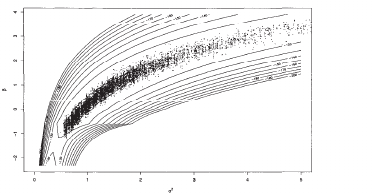



A contour plot of the log-posterior distribution is shown in Fig.1, along with the last 1,000 points of an MCMC sample after 100,000 iterations. This MCMC sample is produced via a simple Gibbs sampler on the posterior distribution where $\beta$ and $\sigma^2$ are alternatively simulated by normal and log-normal random walk proposals, accepted by a one-dimensional Metropolis-Hastings step.

While Example 21 was concerned with convergence difficulties with the Gibbs sampler, this (different) implementation does not seem to face the same problem, at least judging from a simple examination of Fig.1, since the simulated values coincide with the highest region of the log-posterior. Obviously, this is a very crude evaluation, and a more refined assessment is necessary before deciding whether using the MCMC sample represented in Fig.1 in ergodic averages, or increasing the number of simulations to reach a more reliable approximation.

The goal of this chapter is to present, in varying amounts of detail, a catalog of the numerous monitoring methods (or *diagnostics*) proposed in the literature to evaluate aspects of MCMC outputs.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import ndtr as norm_cdf
import arviz as az
import pymc as pm
import pandas as pd
import seaborn as sns

def probit_likelihood(beta, sigma, y, x):
    """
    Calculate the likelihood for the probit model
    
    Parameters:
    -----------
    beta : float
        Regression coefficient
    sigma : float
        Standard deviation parameter
    y : array-like
        Binary response variable (0 or 1)
    x : array-like
        Explanatory variable
    
    Returns:
    --------
    float : Log-likelihood value
    """
    z = x * beta / sigma
    p = norm_cdf(z)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def log_prior(beta, sigma):
    """
    Calculate the log prior for beta and sigma
    
    Parameters:
    -----------
    beta : float
        Regression coefficient
    sigma : float
        Standard deviation parameter
    
    Returns:
    --------
    float : Log-prior value
    """
    # Prior: π(β,σ²) = σ⁻² exp(-1/σ²) exp(-β²/50)
    if sigma <= 0:
        return -np.inf
    return -2 * np.log(sigma) - 1/(sigma**2) - (beta**2)/50

def log_posterior(beta, sigma, y, x):
    """
    Calculate the log posterior for the probit model
    
    Parameters:
    -----------
    beta : float
        Regression coefficient
    sigma : float
        Standard deviation parameter
    y : array-like
        Binary response variable (0 or 1)
    x : array-like
        Explanatory variable
    
    Returns:
    --------
    float : Log-posterior value
    """
    return probit_likelihood(beta, sigma, y, x) + log_prior(beta, sigma)

def metropolis_hastings_probit(y, x, n_iter=100000, beta_init=0, sigma_init=1, 
                              beta_proposal_sd=0.2, sigma_proposal_sd=0.2):
    """
    Metropolis-Hastings sampler for the probit model
    
    Parameters:
    -----------
    y : array-like
        Binary response variable (0 or 1)
    x : array-like
        Explanatory variable
    n_iter : int
        Number of iterations
    beta_init, sigma_init : float
        Initial values for beta and sigma
    beta_proposal_sd, sigma_proposal_sd : float
        Standard deviations for proposal distributions
    
    Returns:
    --------
    tuple : Arrays of samples for beta and sigma
    """
    # Initialize chains
    beta_samples = np.zeros(n_iter)
    sigma_samples = np.zeros(n_iter)
    
    # Set initial values
    beta_samples[0] = beta_init
    sigma_samples[0] = sigma_init
    
    # Current log-posterior
    current_log_posterior = log_posterior(beta_init, sigma_init, y, x)
    
    # Acceptance counters
    beta_accepts = 0
    sigma_accepts = 0
    
    for i in range(1, n_iter):
        # 1. Update beta (given sigma)
        beta_proposal = beta_samples[i-1] + np.random.normal(0, beta_proposal_sd)
        sigma_current = sigma_samples[i-1]
        
        # Calculate log-posterior for proposal
        proposal_log_posterior = log_posterior(beta_proposal, sigma_current, y, x)
        
        # Calculate acceptance probability
        log_acceptance = proposal_log_posterior - current_log_posterior
        
        # Accept or reject
        if np.log(np.random.uniform()) < log_acceptance:
            beta_samples[i] = beta_proposal
            current_log_posterior = proposal_log_posterior
            beta_accepts += 1
        else:
            beta_samples[i] = beta_samples[i-1]
        
        # 2. Update sigma (given beta)
        # Using log-normal proposal for sigma to ensure positivity
        log_sigma_proposal = np.log(sigma_samples[i-1]) + np.random.normal(0, sigma_proposal_sd)
        sigma_proposal = np.exp(log_sigma_proposal)
        beta_current = beta_samples[i]
        
        # Calculate log-posterior for proposal
        proposal_log_posterior = log_posterior(beta_current, sigma_proposal, y, x)
        
        # Calculate acceptance probability (including Jacobian adjustment for log-normal)
        log_acceptance = proposal_log_posterior - current_log_posterior + log_sigma_proposal - np.log(sigma_samples[i-1])
        
        # Accept or reject
        if np.log(np.random.uniform()) < log_acceptance:
            sigma_samples[i] = sigma_proposal
            current_log_posterior = proposal_log_posterior
            sigma_accepts += 1
        else:
            sigma_samples[i] = sigma_samples[i-1]
    
    print(f"Beta acceptance rate: {beta_accepts/n_iter:.2f}")
    print(f"Sigma acceptance rate: {sigma_accepts/n_iter:.2f}")
    
    return beta_samples, sigma_samples

# Set random seed for reproducibility
np.random.seed(42)

# Simulate data
n = 50
x = np.random.normal(0, 1, n)
true_beta = 1.5
true_sigma = 0.8
z = true_beta * x / true_sigma + np.random.normal(0, 1, n)
y = (z > 0).astype(int)

# Run MCMC
n_iter = 100000
beta_samples, sigma_samples = metropolis_hastings_probit(y, x, n_iter=n_iter)

# Discard burn-in (first 20%)
burnin = int(0.2 * n_iter)
beta_samples = beta_samples[burnin:]
sigma_samples = sigma_samples[burnin:]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(beta_samples, 'b-', alpha=0.5)
axes[0].set_title('Trace Plot for β')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('β')

axes[1].plot(sigma_samples, 'r-', alpha=0.5)
axes[1].set_title('Trace Plot for σ')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('σ')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(beta_samples, ax=axes[0])
axes[0].axvline(true_beta, color='r', linestyle='--', label=f'True β = {true_beta}')
axes[0].set_title('Posterior Density of β')
axes[0].set_xlabel('β')
axes[0].legend()

sns.kdeplot(sigma_samples, ax=axes[1])
axes[1].axvline(true_sigma, color='r', linestyle='--', label=f'True σ = {true_sigma}')
axes[1].set_title('Posterior Density of σ')
axes[1].set_xlabel('σ')
axes[1].legend()

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'arviz'

In [ ]:
def calculate_log_posterior_grid(beta_range, sigma_range, y, x, n_grid=100):
    """Calculate log posterior values on a grid"""
    beta_grid = np.linspace(beta_range[0], beta_range[1], n_grid)
    sigma_grid = np.linspace(sigma_range[0], sigma_range[1], n_grid)
    
    log_post = np.zeros((n_grid, n_grid))
    
    for i, beta in enumerate(beta_grid):
        for j, sigma in enumerate(sigma_grid):
            log_post[j, i] = log_posterior(beta, sigma, y, x)
    
    return beta_grid, sigma_grid, log_post

# Calculate log posterior on grid
beta_range = (0, 5)
sigma_range = (0.2, 3)
beta_grid, sigma_grid, log_post = calculate_log_posterior_grid(beta_range, sigma_range, y, x)

# Plot contours with MCMC samples
plt.figure(figsize=(10, 8))

# Plot contours
X, Y = np.meshgrid(beta_grid, sigma_grid)
contour = plt.contour(X, Y, log_post, 20, colors='gray')
plt.clabel(contour, inline=1, fontsize=8)

# Plot last 1000 MCMC samples
plt.scatter(beta_samples[-1000:], sigma_samples[-1000:], s=1, alpha=0.5, color='black')

plt.xlabel('β')
plt.ylabel('σ')
plt.title('Contour plot of log-posterior with last 1000 MCMC samples')
plt.xlim(beta_range)
plt.ylim(sigma_range)
plt.show()

def run_multiple_chains(y, x, n_chains=4, n_iter=50000):
    """Run multiple chains for Gelman-Rubin diagnostic"""
    # Initialize storage for multiple chains
    chains_beta = np.zeros((n_chains, n_iter))
    chains_sigma = np.zeros((n_chains, n_iter))
    
    for i in range(n_chains):
        # Different starting points
        beta_init = np.random.uniform(0, 3)
        sigma_init = np.random.uniform(0.5, 2)
        
        # Run chain
        beta, sigma = metropolis_hastings_probit(y, x, n_iter=n_iter, 
                                                beta_init=beta_init, 
                                                sigma_init=sigma_init)
        
        chains_beta[i, :] = beta
        chains_sigma[i, :] = sigma
    
    return chains_beta, chains_sigma

# Run multiple chains
n_chains = 4
chains_beta, chains_sigma = run_multiple_chains(y, x, n_chains=n_chains)

# Calculate Gelman-Rubin statistic
def gelman_rubin(chains):
    """Calculate Gelman-Rubin R-hat statistic"""
    n_chains, n_iter = chains.shape
    
    # Calculate between-chain variance
    chain_means = np.mean(chains, axis=1)
    B = n_iter * np.var(chain_means, ddof=1)
    
    # Calculate within-chain variance
    W = np.mean(np.var(chains, axis=1, ddof=1))
    
    # Calculate variance estimate
    var_hat = ((n_iter - 1) / n_iter) * W + (1 / n_iter) * B
    
    # Calculate R-hat
    R_hat = np.sqrt(var_hat / W)
    
    return R_hat

# Calculate R-hat for both parameters
r_hat_beta = gelman_rubin(chains_beta[:, int(0.5 * n_iter):])  # Using second half of chains
r_hat_sigma = gelman_rubin(chains_sigma[:, int(0.5 * n_iter):])

print(f"Gelman-Rubin R-hat for β: {r_hat_beta:.4f}")
print(f"Gelman-Rubin R-hat for σ: {r_hat_sigma:.4f}")

def effective_sample_size(chain):
    """Calculate effective sample size using autocorrelation"""
    n = len(chain)
    
    # Calculate autocorrelation
    acf = np.correlate(chain - np.mean(chain), chain - np.mean(chain), mode='full')
    acf = acf[n-1:] / acf[n-1]
    
    # Find where autocorrelation drops below 0.05
    cutoff = np.where(acf < 0.05)[0]
    if len(cutoff) > 0:
        max_lag = cutoff[0]
    else:
        max_lag = min(int(n/3), 1000)  # Cap at 1000 or n/3
    
    # Calculate effective sample size
    ess = n / (1 + 2 * np.sum(acf[1:max_lag]))
    
    return ess

ess_beta = effective_sample_size(beta_samples)
ess_sigma = effective_sample_size(sigma_samples)

print(f"Effective sample size for β: {ess_beta:.1f} (out of {len(beta_samples)} samples)")
print(f"Effective sample size for σ: {ess_sigma:.1f} (out of {len(sigma_samples)} samples)")

def geweke_diagnostic(chain, first=0.1, last=0.5):
    """
    Calculate Geweke diagnostic (z-score) for a chain
    Compares means from first and last portions of the chain
    """
    n = len(chain)
    first_idx = int(first * n)
    last_idx = int(last * n)
    
    # Get samples from first and last portions
    first_samples = chain[:first_idx]
    last_samples = chain[-last_idx:]
    
    # Calculate means
    first_mean = np.mean(first_samples)
    last_mean = np.mean(last_samples)
    
    # Calculate spectral density estimates (using simplified method)
    # In practice, you'd want to use a proper spectral density estimator
    first_var = np.var(first_samples) / len(first_samples)
    last_var = np.var(last_samples) / len(last_samples)
    
    # Calculate z-score
    z = (first_mean - last_mean) / np.sqrt(first_var + last_var)
    
    return z

z_beta = geweke_diagnostic(beta_samples)
z_sigma = geweke_diagnostic(sigma_samples)

print(f"Geweke z-score for β: {z_beta:.4f}")
print(f"Geweke z-score for σ: {z_sigma:.4f}")
print("Values between -2 and 2 suggest convergence.")

plt.figure(figsize=(12, 10))

# Plot traces for beta
plt.subplot(2, 1, 1)
for i in range(n_chains):
    plt.plot(chains_beta[i, :], alpha=0.7, label=f'Chain {i+1}')
plt.title('Trace Plots for β (Multiple Chains)')
plt.xlabel('Iteration')
plt.ylabel('β')
plt.legend()

# Plot traces for sigma
plt.subplot(2, 1, 2)
for i in range(n_chains):
    plt.plot(chains_sigma[i, :], alpha=0.7, label=f'Chain {i+1}')
plt.title('Trace Plots for σ (Multiple Chains)')
plt.xlabel('Iteration')
plt.ylabel('σ')
plt.legend()

plt.tight_layout()
plt.show()



##  Convergence Criteria

From a general point of view, there are three (increasingly stringent) types of convergence for which assessment is necessary:

### (i) Convergence to the Stationary Distribution

This criterion considers convergence of the chain $\theta^{(t)}$ to the stationary distribution $f$ (or *stationarization*), which seems to be a minimal requirement for an algorithm that is supposed to approximate simulation from $f$. Unfortunately, it seems that this approach to convergence issues is not particularly fruitful. In fact, from a theoretical point of view, $f$ is only the *limiting distribution* of $\theta^{(t)}$. This means that stationarity is only achieved asymptotically.

However, the original implementation of the Gibbs sampler was based on the generation of $n$ independent initial values $\theta^{(t)}$ $(t = 1, \ldots, n$), and the storage of only the last simulation $\theta^{(T)}$ in each chain, while initial iterate to some extent—the larger $T$ is, the closer $\theta^{(T)}$ is to the stationary distribution—this criterion is missing the point. If $\theta^{(T)}$ is the (initial) distribution of $\theta^{(0)}$, then the $\theta^{(T)}$’s are all distributed from $f_N$. In addition, this also results in a waste of resources, as most of the generated variables are discarded.

If we, instead, consider only a single realization (or path) of the chain $\theta^{(t)}$, the question of convergence to the limiting distribution is not really relevant: Indeed, it is possible to obtain the initial value $\theta^{(0)}$ from the stationary $f$, and therefore to act as if the chain is already in its stationary regime from the start, meaning that $\theta^{(t)}$ *belongs to an area of likely (enough) values for* $f$.

This seeming dismissal of the first type of control may appear rather cavalier, but we do think that convergence to $f$ per se is not the major issue for most MCMC algorithms in the sense that the chain truly produced by the

> *Historically, there was a flurry of papers at the end of the 90s concerned with the development of convergence diagnoses. This flurry has now quieted down, the main reason being that no criterion is absolutely foolproof, as we will see later in this chapter. As we will see again in the introduction of Chapter 13, the only way of being certain algorithms has converged is to use iid sampling! This perspective obviously oversimplifies the issue. As already seen in the case of renewal and coupling, there exist finite instances where the chain is known to be in the stationary distribution (see Section 12.2.3).*

We consider statistical setup where the support of $f$ is approximately known. This may not be the case for high-dimensional setups or complex structures where the algorithm is initialized at random.

## (ii) Convergence of Averages

Here, as in regular Monte Carlo settings, we are concerned with convergence of the empirical average

$$
\frac{1}{T} \sum_{t=1}^{T} h(\theta^{(t)})
$$

to $E_f[h(\theta)]$ for an arbitrary function $h$. This type of convergence is most relevant in the implementation of MCMC algorithms. Indeed, even when $\theta^{(t)} \sim f$, the exploration of the complexity of $f$ by the chain $\theta^{(t)}$ can be more or less lengthy, depending on the transition chosen for the algorithm. The purpose of the convergence assessment is, therefore, to determine whether the chain has exhibited all the features of $f$ (for instance, all the modes). Brooks and Roberts (1998) relate this convergence to the mixing speed of the chain, in the informal sense of a strong (or weak) dependence on initial conditions and in a slow (or fast) exploration of the support of $f$ (see also Asmussen et al. 1994 for a formal version of convergence monitoring in this setup).

While the ergodic theorem guarantees the convergence of this average from a theoretical point of view, the relevant issue at this stage is to determine a minimal value for $T$ which justifies the approximation of $E_f[h(\theta)]$ by (12.1) for a given level of accuracy.

## (iii) Convergence to iid Sampling

This convergence criterion measures how close a sample $\{\theta^{(1)}, \ldots, \theta^{(k)}\}$ is to being iid. Rather than approximating integrals such as $E_f[h(\theta)]$, the goal is to produce variables $\theta_i$ which are (quasi-)independent. While the solution is based on parallel chains mentioned above is not satisfactory, an alternative is to use subsampling (or *batch sampling*) to reduce correlation between the successive points of the Markov chain. This technique, which is customarily used in numerical simulation (see, for instance, Schmeiser 1989) subsamples the chain $\{\theta^{(t)}\}$ with a batch size $k$, considering only the values $\theta^{(t)} = \theta^{(kt)}$. If the covariance $\text{cov}(\theta^{(t)}, \theta^{(kt)})$ decreases monotonically with $t$ (see Section 9.3), the motivation for subsampling is obvious. In particular, if the chain $\{\theta^{(t)}\}$ satisfies an interleaving property (see Section 9.2.2), subsampling is justified.

##  Multiple Chains

Aside from distinguishing between convergence to stationarity (Section 12.2) and convergence of the average (Section 12.3), we also distinguish between the methods involving the parallel simulation of $M$ independent chains $\{\theta_k^{(t)}\}$, $1 \leq k \leq M$, and those based on a single "on-line" chain. The motivation for the former is intuitively sound. By simulating several chains, variability and dependence on the initial values are reduced and it should be easier to control convergence of the stationary distribution by comparing the estimation, using different chains, of quantities of interest. The dangers of a naive implementation of this principle should be obvious, namely that the slower chain governs convergence and that the choice of the initial distribution is extremely important in guaranteeing that the different chains are well dispersed.

Many multiple-chain convergence diagnostics are quite elaborate (Gelman and Rubin 1992, Liu et al. 1992) and seem to propose convergence evaluations that are more robust than single-chain methods. Geyer (1992) points out that robustness may be illusory from several points of view. In fact, good performances of these parallel methods require a degree of a priori knowledge on the distribution $f$ in order to construct an initial distribution $\theta^{(0)}$ which takes into account the features of $f$ (modes, shape of high density regions, etc.). For example, an initial distribution which is too concentrated around a local mode of $f$ does not contribute significantly more than a single chain to the exploration of $f$. Moreover, slow algorithms, like Gibbs sampling used in highly nonlinear setups, usually favor single chains, in the sense that a unique chain with $MT$ observations and a slow rate of mixing is more likely to get closer to the stationary distribution than $M$ chains of size $T$, which will presumably stay in the neighborhood of the starting point with higher probability.

An additional practical drawback of parallel methods is that they require a modification of the original MCMC algorithm to deal with the processing of parallel outputs (see Tierney 1994 and Raftery and Lewis 1996 for other criticisms). On the other hand, single-chain methods suffer more severely from the fact that the mixing properties of the chain may not be good for all $f$ or that part of the support of $f$ which has not been visited by the chain at time $T$ is almost impossible to detect. Moreover, a single chain may present probabilistic pathologies which are possibly avoided by parallel chains (see the example of Figure 12.16, as opposed to the sequential importance sampling resolution of Section 14.4.4).

As discussed in Chapter 14, and in particular in the population Monte Carlo section, Section 14.4, there exist alternative ways of taking advantage of parallel chains to improve and study convergence, in particular for a better assessment of the entire support of $f$. These algorithms outside the MCMC criteria can also be used as benchmarks to test the convergence of the MCMC algorithms.

However, checking for the monotone decrease of $\text{cov}(\theta_k^{(t)}, \theta_k^{(t')})$—which also justifies Rao-Blackwellization (see Section 9.3)—is not always possible and, in some settings, the convergence oscillates with $t$, which complicates the choice of $k$.

We note that subsampling necessarily leads to losses in efficiency with regard to the second convergence goal. In fact, as shown by MacEachern and Berliner (1994), it is always preferable to use the entire sample for the approximation of $E_f[h(\theta)]$. Nonetheless, for convergence assessment, subsampling may be beneficial (see, e.g., Robert et al. 1999).

**Lemma 12.2.** *Suppose $h \subset C^1(f)$ and $\{\theta_k^{(t)}\}$ is a Markov chain with stationary distribution $f$. If*

$$
\theta_k = \frac{1}{TK} \sum_{t=1}^{TK} h(\theta_k^{(t)}) \quad \text{and} \quad \theta_k = \frac{1}{T} \sum_{t=1}^{T} h(\theta_k^{(tK)}),
$$

*the variance of \(\theta_k\) satisfies*

$$
\text{var}(\theta_k) \leq \text{var}(\theta_k),
$$

*for every \(k > 1\)*.

**Proof.** Define \(\theta_k^1, \ldots, \theta_k^{k-1}\) as the shifted versions of \(\theta_k\); that is,

$$
\theta_k^i = \frac{1}{T} \sum_{t=1}^{T} h(\theta_k^{(tK-i)}), \quad i = 0, \ldots, k-1.
$$

The estimator \(\theta_k\) can then be written as \(\theta_k = \frac{1}{k} \sum_{i=0}^{k-1} \theta_k^i\), and hence

$$
\text{var}(\theta_k) = \text{var} \left( \frac{1}{k} \sum_{i=0}^{k-1} \theta_k^i \right) = \frac{1}{k^2} \sum_{i=0}^{k-1} \text{var}(\theta_k^i) + \frac{1}{k^2} \sum_{i \neq j} \text{cov}(\theta_k^i, \theta_k^j) k^2
$$

$$
\leq \text{var}(\theta_k^i)/k + \frac{1}{k^2} \sum_{i \neq j} \text{var}(\theta_k^i) k^2
$$

$$
= \text{var}(\theta_k),
$$

where the inequality follows from the Cauchy-Schwarz inequality

$$
[\text{cov}(\theta_k^i, \theta_k^j)] \leq \text{var}(\theta_k).
$$

In the remainder of the chapter, we consider only independence issues in cases where they have bearing on the control of the chain, as in renewal theory (see Section 12.2.3). Indeed, for an overwhelming majority of cases where MCMC algorithms are used, independence is not a necessary feature.

##  Monitoring Reconsidered

We agree with many authors that it is somewhat of an illusion to think we can control the flow of a Markov chain and assess its convergence behavior from a few realizations of this chain. There are always settings (transition kernels) which, for most realizations, will invalidate an arbitrary indicator (whatever its theoretical justification) and the randomness inherent to the nature of the problem prevents any categorical guarantee of performance. The heart of the difficulty is the key problem of statistics, where the uncertainty due to the observations prohibits categorical conclusions and final statements. Far from being a failure acknowledgment, these remarks only aim at warning the reader about the relative value of the indicators developed below. As noted by Cowles and Carlin (1996), it is simply inconceivable, in the light of recent results, to envision automated *stopping rules*. Brooks and Roberts (1998) also stress that the prevalence of a given control method strongly depends on the model and on the inferential problem under study. It, therefore, even more crucial to develop robust and

Gelman-Rubin Statistic (R-hat): 1.0004


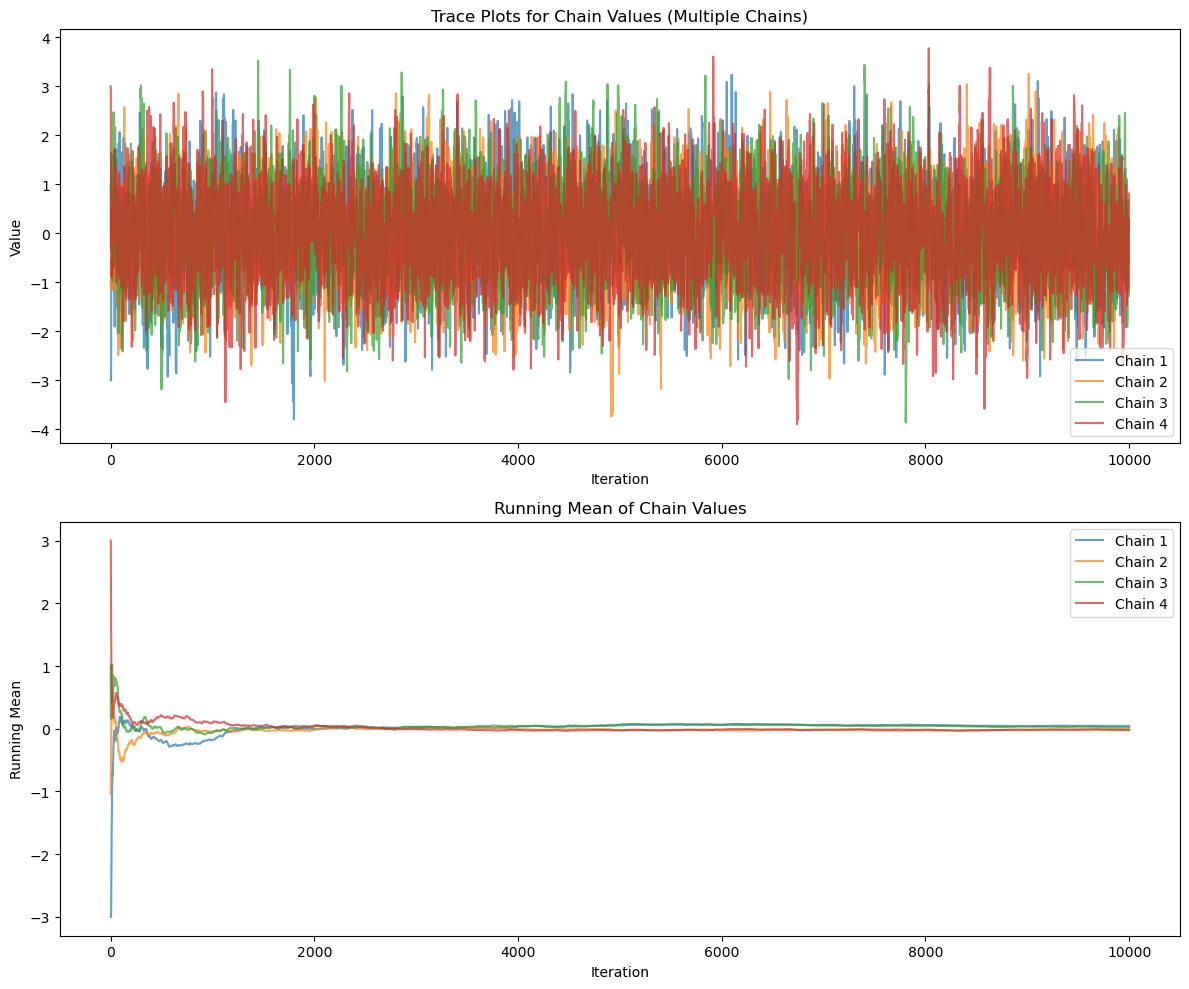


Discussion:
- The Metropolis-Hastings algorithm samples from the target distribution by proposing new states and accepting or rejecting them based on the acceptance ratio.
- The Gelman-Rubin statistic (R-hat) compares within-chain and between-chain variances. A value close to 1 indicates convergence.
- Trace plots help visualize the mixing of the chains. Good mixing is indicated by chains exploring the parameter space without sticking to one region.

Notes:
- This is a simplified implementation. For real applications, you might need to:
  - Add a burn-in period (discard initial iterations).
  - Use thinning (subsampling to reduce autocorrelation).
  - Use more sophisticated target distributions.
- The current date is March 12, 2025, and I am Grok 3, built by xAI.


In [3]:
# mcmc_implementation.py
# Implementation of MCMC with Multiple Chains and Convergence Diagnostics
# Date: March 12, 2025
# Author: Grok 3, built by xAI

import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev

# Define Target Distribution and Proposal
# Target distribution: N(0, 1)
def target_distribution(x):
    return np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)

# Proposal distribution (normal with standard deviation sigma_prop)
sigma_prop = 1.0
def propose(current):
    return current + np.random.normal(0, sigma_prop)

# Acceptance probability
def acceptance_ratio(current, proposed):
    return min(1, target_distribution(proposed) / target_distribution(current))

# Metropolis-Hastings Algorithm with Multiple Chains
def metropolis_hastings(n_iterations, n_chains, initial_values):
    chains = np.zeros((n_chains, n_iterations))
    chains[:, 0] = initial_values  # Initialize each chain with different starting points
    
    for i in range(n_chains):
        current = chains[i, 0]
        for t in range(1, n_iterations):
            proposed = propose(current)
            if np.random.uniform(0, 1) < acceptance_ratio(current, proposed):
                current = proposed
            chains[i, t] = current
    return chains

# Parameters
n_iterations = 10000
n_chains = 4
initial_values = np.array([-3.0, -1.0, 1.0, 3.0])  # Different starting points for each chain

# Run MCMC
chains = metropolis_hastings(n_iterations, n_chains, initial_values)

# Convergence Diagnostic: Gelman-Rubin Statistic
def gelman_rubin(chains):
    n_iterations = chains.shape[1]
    n_chains = chains.shape[0]
    
    # Within-chain variance
    W = np.mean([np.var(chain) for chain in chains])
    
    # Between-chain variance
    theta_bar = np.mean(chains, axis=1)
    theta_grand = np.mean(theta_bar)
    B = n_iterations / (n_chains - 1) * np.sum((theta_bar - theta_grand)**2)
    
    # Pooled variance
    var_hat = ((n_iterations - 1) / n_iterations) * W + (1 / n_iterations) * B
    R_hat = np.sqrt(var_hat / W)
    return R_hat

# Calculate Gelman-Rubin statistic
R_hat = gelman_rubin(chains)
print(f"Gelman-Rubin Statistic (R-hat): {R_hat:.4f}")
# Convergence is suggested if R-hat is close to 1 (e.g., < 1.1)

# Visualize Trace Plots
plt.figure(figsize=(12, 10))

# Plot traces for chain values
plt.subplot(2, 1, 1)
for i in range(n_chains):
    plt.plot(chains[i, :], alpha=0.7, label=f'Chain {i+1}')
plt.title('Trace Plots for Chain Values (Multiple Chains)')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()

# Plot running mean of chain values
plt.subplot(2, 1, 2)
running_means = np.cumsum(chains, axis=1) / np.arange(1, n_iterations + 1)
for i in range(n_chains):
    plt.plot(running_means[i, :], alpha=0.7, label=f'Chain {i+1}')
plt.title('Running Mean of Chain Values')
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.legend()

plt.tight_layout()
plt.show()

# Discussion (printed as text)
print("\nDiscussion:")
print("- The Metropolis-Hastings algorithm samples from the target distribution by proposing new states and accepting or rejecting them based on the acceptance ratio.")
print("- The Gelman-Rubin statistic (R-hat) compares within-chain and between-chain variances. A value close to 1 indicates convergence.")
print("- Trace plots help visualize the mixing of the chains. Good mixing is indicated by chains exploring the parameter space without sticking to one region.")
print("\nNotes:")
print("- This is a simplified implementation. For real applications, you might need to:")
print("  - Add a burn-in period (discard initial iterations).")
print("  - Use thinning (subsampling to reduce autocorrelation).")
print("  - Use more sophisticated target distributions.")
print(f"- The current date is March 12, 2025, and I am Grok 3, built by xAI.")